In [1]:
import os
from glob import glob

import dask
import numpy as np
import pandas as pd
import xarray as xr

import metric_funcs as mf

In [8]:
ds = xr.open_mfdataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/LOCA2/avg_tasmin_MPI-ESM1-2-LR_r4i1p1f1_ssp370_*.nc')

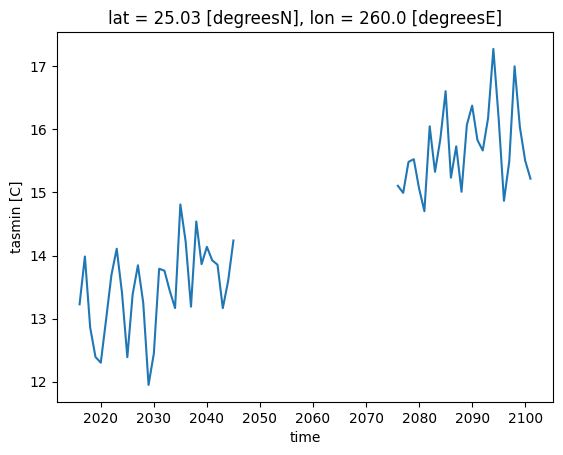

In [10]:
ds.sel(lat=25, lon=260, method='nearest')['tasmin'].plot()

## Calculate metrics 

### Preliminaries

In [2]:
################
#### Paths #####
################
# NOTE: this is run on a different system from other datasets
# Update these for reproduction
from utils import hopper_code_path as project_code_path
from utils import hopper_data_path as project_data_path

gard_path = "/home/shared/vs498_0001/GARD-LENS" # GARD-LENS raw
gard_gcms = ['canesm5', 'cesm2', 'ecearth3']

In [3]:
# Check all same
gardlens_info = {}

for gcm in gard_gcms: 
    t_mean_files = glob(f"{gard_path}/t_mean/GARDLENS_{gcm}_*.nc")
    t_range_files = glob(f"{gard_path}/t_range/GARDLENS_{gcm}_*.nc")
    pcp_files = glob(f"{gard_path}/pcp/GARDLENS_{gcm}_*.nc")
    assert len(t_mean_files) == len(t_range_files)
    assert len(t_mean_files) == len(pcp_files)

In [4]:
# Get all model members
models_members = glob(f"{gard_path}/t_mean/GARDLENS_*.nc")
models_members = [file.split('GARDLENS')[1].split('t_')[0][1:-1] for file in models_members]

In [5]:
###############################
# Metric calulcation function #
###############################
def calculate_metric(metric_func, var_id, model_member, needed_vars, gard_path, out_path):
    """
    Inputs: selected model, member, variable, and metric to calculate (from GARD-LENS)
    Outputs: calculated (annual) metric
    """
    try:
        # Check if done
        if os.path.isfile(out_path):
            # print(f"{model_member} already done.")
            return None

        # Read
        if model_member.split('_')[0] == 'ecearth3':
            time_range = '1970_2100'
        else:
            time_range = '1950_2100'
            
        # Read
        ds_tmp = xr.merge([xr.open_dataset(f"{gard_path}/{var}/GARDLENS_{model_member}_{var}_{time_range}_CONUS.nc", chunks='auto') for var in needed_vars])
    
        # Calculate metric
        ds_out = metric_func(ds_tmp, var_id)
    
        # Store
        ds_out.to_netcdf(out_path)
        print(f"{model_member}")
            
    # Log if error
    except Exception as e:
        except_path = f"{project_code_path}/scripts/logs"
        with open(f"{except_path}/{model_member}_{var_id}_GARDLENS.txt", "w") as f:
            f.write(str(e))

In [ ]:
############
### Dask ###
############
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers = 20)
client = cluster.get_client()
client

### Calculations

In [7]:
%%time
##############################
# Average temperature
##############################
var_id = 'tas'
metric_func = mf.calculate_avg
needed_vars = ['t_mean']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/avg_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 2.83 ms, sys: 2.15 ms, total: 4.98 ms
Wall time: 14.8 ms


In [8]:
%%time
##############################
# Maximum temperature: avg
##############################
var_id = 'tasmax'
metric_func = mf.calculate_avg
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/avg_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

cesm2_1251_14
canesm5_r20i1p2f1
ecearth3_r113i1p1f1
ecearth3_r150i1p1f1
CPU times: user 43.3 s, sys: 14.9 s, total: 58.2 s
Wall time: 14min 53s


In [9]:
%%time
##############################
# Maximum temperature: max
##############################
var_id = 'tasmax'
metric_func = mf.calculate_max
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/max_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 9.36 ms, sys: 4.44 ms, total: 13.8 ms
Wall time: 45.4 ms


In [10]:
%%time
##############################
# Minimum temperature: avg
##############################
var_id = 'tasmin'
metric_func = mf.calculate_avg
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/avg_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

canesm5_r15i1p1f1
ecearth3_r126i1p1f1


Type = File(72057594037928008) name='/'2025-03-24 12:11:54,555 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('store-map-b1a5964f07353fc00840118eb5d2aa43', 0, 0, 1),)


canesm5_r16i1p1f1
canesm5_r3i1p1f1
ecearth3_r117i1p1f1
cesm2_1281_13
CPU times: user 1min 13s, sys: 24.6 s, total: 1min 38s
Wall time: 24min 15s


In [11]:
%%time
##############################
# Minimum temperature: min
##############################
var_id = 'tasmin'
metric_func = mf.calculate_min
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/min_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 25 ms, sys: 5.31 ms, total: 30.3 ms
Wall time: 120 ms


In [12]:
%%time
#################
# Maximum precip
#################
var_id = 'pr'
metric_func = mf.calculate_max
needed_vars = ['pcp']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/max_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 5.53 ms, sys: 3.48 ms, total: 9 ms
Wall time: 48.3 ms


In [13]:
%%time
#################
# Sum precip
#################
var_id = 'pr'
metric_func = mf.calculate_sum
needed_vars = ['pcp']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/sum_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 5.28 ms, sys: 2.78 ms, total: 8.06 ms
Wall time: 56.4 ms


In [14]:
%%time
##############################
# Cooling degree days: max
##############################
var_id = 'cdd'
metric_func = mf.calculate_dd_max
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/max_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 1.11 ms, sys: 3.56 ms, total: 4.66 ms
Wall time: 15.9 ms


In [15]:
%%time
##############################
# Cooling degree days: sum
##############################
var_id = 'cdd'
metric_func = mf.calculate_dd_sum
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/sum_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 15.3 ms, sys: 7.28 ms, total: 22.6 ms
Wall time: 110 ms


In [16]:
%%time
##############################
# Heating degree days: max
##############################
var_id = 'hdd'
metric_func = mf.calculate_dd_max
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/max_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 9.95 ms, sys: 7.18 ms, total: 17.1 ms
Wall time: 94.7 ms


In [17]:
%%time
##############################
# Heating degree days: sum
##############################
var_id = 'hdd'
metric_func = mf.calculate_dd_sum
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/sum_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 4.84 ms, sys: 1.27 ms, total: 6.11 ms
Wall time: 34.5 ms
